In [1]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
data = get_zeolite('MOR')

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [3]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [20]:
def get_ats(idx):
    with open(f'Data_isotherms/isomors/MOR_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/curves/plot_data_{idx}') as f:
        lines = f.read()
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)

    p = [float(i) for i in p]
    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [5]:
n = 989

atoms = np.zeros((n, 48))
iso_params = np.zeros((n, 6))


for zeo in tqdm(range(n)):

    atoms[zeo] = get_ats(zeo)
    iso_params[zeo] = get_iso(zeo)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 989/989 [00:15<00:00, 63.72it/s]


In [107]:
a = langmuirfreudlich(trainloader.dataset.y, torch.tensor(np.tile((10**np.arange(1,8,7/100))[:, None], (1,904)))).T

In [108]:
np.isnan(a).sum()

tensor(0)

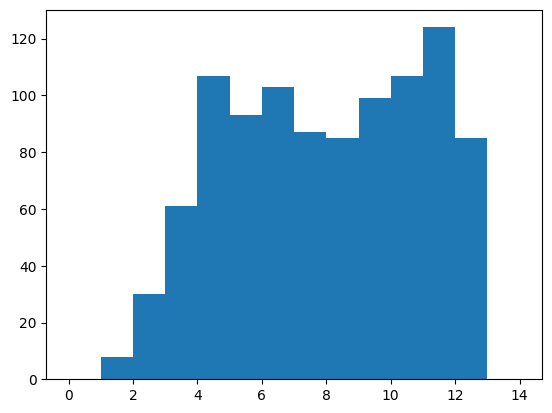

In [22]:
plt.hist(atoms.sum(1), bins=np.arange(0, 15));

In [23]:
def get_pred_points(steps):

    return 10**np.arange(1,8,1/steps)
    

In [109]:
class calculate_distance(nn.Module):

    def __init__(self, n_points=100):
        super().__init__()

        self.points = torch.tensor(10**np.arange(1,8,7/n_points))[:, None]
        self.n_points = n_points
        
    def forward(self, param_p_hat, param_p):
        # add channels dimension
        param_p_hat = param_p_hat[:,None]

        
        p_hat = F.interpolate(param_p_hat, self.n_points, align_corners=True, mode='linear').squeeze()
        #print('p_hat', torch.isnan(p_hat).sum())
        points = self.points.repeat(1, param_p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        print('p', torch.isnan(p).sum())    
        loss = ((p_hat - p)**2).sum(1)
        print(loss)
        return loss
        

        
    

In [110]:
pred_points = get_pred_points(5)

In [111]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                centers=10, mx_d=6, width=1, pool='sum', 
                out_size=len(pred_points)).to('cuda')

In [90]:
_, testloader, trainloader = get_data_pore(atoms, iso_params, edges, pore, edges_sp, edges_ps, bs=32, sub_lim=12, p=1)

In [91]:
mpnn.fit(trainloader, testloader, epochs=10, crit=calculate_distance, crit_kwargs={'n_points':20}, opt=optim.Adam, opt_kwargs={'lr':0.0001}, scale_loss=False)

  0%|                                                                                                                      | 0/10 [00:00<?, ?epoch/s, loss]

p_hat tensor(0, device='cuda:0')
p tensor(5, device='cuda:0')
tensor([227.9177, 115.3874, 200.8725, 127.4615, 210.7323, 388.5795, 294.2296,
        169.8111, 124.3674, 121.7246, 122.5267, 132.5103, 206.1998, 274.0251,
        358.3277, 111.3720, 136.0243, 279.4631, 284.4764, 120.5112, 145.9904,
        137.3494, 206.5134, 132.9934,      nan, 164.7204, 159.0832, 114.8588,
        112.2703, 178.9347, 151.4815, 145.1203], device='cuda:0',
       grad_fn=<SumBackward1>)
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackward1>)
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan],

 10%|█████████                                                                                 | 1/10 [00:04<00:40,  4.56s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(13, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBack

 20%|██████████████████                                                                        | 2/10 [00:09<00:36,  4.57s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(19, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBack

 30%|███████████████████████████                                                               | 3/10 [00:13<00:32,  4.58s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

 40%|████████████████████████████████████                                                      | 4/10 [00:18<00:27,  4.61s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

 50%|█████████████████████████████████████████████                                             | 5/10 [00:23<00:23,  4.64s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

 60%|██████████████████████████████████████████████████████                                    | 6/10 [00:27<00:18,  4.61s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

 70%|██████████████████████████████████████████████████████████████▉                           | 7/10 [00:32<00:13,  4.58s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(14, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBack

 80%|████████████████████████████████████████████████████████████████████████                  | 8/10 [00:36<00:09,  4.61s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

 90%|█████████████████████████████████████████████████████████████████████████████████         | 9/10 [00:41<00:04,  4.67s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SumBackw

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.62s/epoch, loss: nan test loss: nan]

p_hat tensor(640, device='cuda:0')
p tensor(7, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(640, device='cuda:0')
p tensor(0, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
p_hat tensor(420, device='cuda:0')
p tensor(9, device='cuda:0')
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0')


([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

In [83]:
a.shape

(100,)